In [1]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as mdates

%matplotlib inline

## Read porftolio function

In [2]:
def read_portfolio(filename):
    df = pd.read_csv(filename)
    
    row = df.iloc[0]
    
    portfolio = {
        'error': row['Error'],
        'weights': json.loads(row['Portfolio Weights']),
        'performance': {
            'train_performance': {
                'tracking_error': row['Train Tracking Error'],
                'root_mean_squared_error': row['Train RMSE'],
                'correlation': row['Train Correlation']
            },
            'test_performance': {
                'tracking_error': row['Test Tracking Error'],
                'root_mean_squared_error': row['Test RMSE'],
                'correlation': row['Test Correlation']
            }
        },
        'optimization_time': row['Optimization Time'],
        'mip_gap': row['Mip Gap'],
        'dates': {
            'train': {
                'start': row['Start train'],
                'end': row['End train'],
            },
            'test': {
                'start': row['Start test'],
                'end': row['End test'],
            }
        }
    }
    return portfolio

## Plot functions

In [3]:
def plot_portfolio(portfolio, stocks_data, index_data, start_date, end_date, index_name, yaxis_name='Cumulative Returns'):
    # Convertendo as datas para Timestamps
    test_start = pd.Timestamp(portfolio['dates']['test']['start'])
    test_end = pd.Timestamp(portfolio['dates']['test']['end'])
    train_start = pd.Timestamp(portfolio['dates']['train']['start'])
    train_end = pd.Timestamp(portfolio['dates']['train']['end'])

    portfolio_weights = portfolio['weights']
    selected_stocks = stocks_data.columns
    weights = pd.Series(portfolio_weights).reindex(selected_stocks).values
    portfolio_data_filtered = (stocks_data * weights).sum(axis=1).loc[start_date:end_date]
    index_data_filtered = index_data.loc[start_date:end_date]

    # Garantir que os índices sejam do tipo DatetimeIndex
    portfolio_data_filtered.index = pd.to_datetime(portfolio_data_filtered.index)
    index_data_filtered.index = pd.to_datetime(index_data_filtered.index)

    # Encontrar o dia seguinte mais próximo de test_start no índice
    available_dates = portfolio_data_filtered.index
    next_date = available_dates[available_dates >= test_start].min()  # Dia mais próximo >= test_start
    
    if pd.isna(next_date):
        print("Warning: No available date after test_start in the plotting range.")
        next_date = None

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    axis = fig.add_axes([0, 0, 1, 1], facecolor='black')

    if(index_name=='S&P100'):
        color='red'
    else:
        color='royalblue'

    # Plotar os dados
    axis.plot(index_data_filtered.index, index_data_filtered, color=color, linestyle='-', linewidth=3, label=index_name)
    axis.plot(portfolio_data_filtered.index, portfolio_data_filtered, color='gold', linestyle='--', linewidth=2, label="Portfolio")

    # Adicionar a linha no próximo dia disponível após test_start
    if next_date:
        axis.axvline(x=next_date, color='white', linestyle='--', linewidth=2, label='Test Start (Adjusted)')
        axis.text(next_date, axis.get_ylim()[1] * 0.9, 'Test Start', 
                  rotation=90, verticalalignment='top',
                  horizontalalignment='right', 
                  color='white', fontsize=12)

    axis.set_xticks(index_data_filtered.index[::30])
    axis.set_ylim([0.9, 1.5])
    axis.set_title(f"Portfolio {len(portfolio_weights)} stocks {index_name}: {start_date} to {end_date}", fontsize=25, pad=20, color='white')
    axis.legend(title="Indicator", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')
    axis.set_ylabel(yaxis_name, fontsize=20, color='white')
    axis.set_xlabel('Date', fontsize=20, color='white')
    axis.tick_params(colors='white')
    axis.grid(color='gray', linestyle='--')

    plt.show()


In [4]:
def plot_portfolio2(portfolio, portfolio_rebalance, stocks_data, index_data, start_date, end_date, index_name, yaxis_name='Cumulative Returns'):
    # Convertendo as datas para Timestamps
    test_start = pd.Timestamp(portfolio['dates']['test']['start'])
    test_end = pd.Timestamp(portfolio['dates']['test']['end'])
    train_start = pd.Timestamp(portfolio['dates']['train']['start'])
    train_end = pd.Timestamp(portfolio['dates']['train']['end'])
    portfolio_weights = portfolio['weights']
    train_start_rebalance = pd.Timestamp(portfolio_rebalance['dates']['train']['start'])
    train_end_rebalance = pd.Timestamp(portfolio_rebalance['dates']['train']['end'])
    portfolio_weights_rebalance = portfolio_rebalance['weights']
    
    selected_stocks = stocks_data.columns
    index_data_filtered = index_data.loc[start_date:end_date]
    
    weights = pd.Series(portfolio_weights).reindex(selected_stocks).values
    portfolio_data_filtered = (stocks_data * weights).sum(axis=1).loc[start_date:train_start_rebalance]
    
    weights_rebalance = pd.Series(portfolio_weights_rebalance).reindex(selected_stocks).values
    portfolio_data_filtered_rebalance = (stocks_data * weights_rebalance).sum(axis=1).loc[train_start_rebalance:end_date]
    
    # Usar método de concatenação que preserva os índices
    full_portfolio_data_filtered = pd.concat([portfolio_data_filtered, portfolio_data_filtered_rebalance], axis=0)
    
    print(full_portfolio_data_filtered.shape)
    print(portfolio_data_filtered.shape)
    print(portfolio_data_filtered_rebalance.shape)
    print(index_data_filtered.shape)
    
    # Garantir que os índices sejam do tipo DatetimeIndex
    full_portfolio_data_filtered.index = pd.to_datetime(full_portfolio_data_filtered.index)
    index_data_filtered.index = pd.to_datetime(index_data_filtered.index)
    
    # Encontrar o dia seguinte mais próximo de test_start no índice
    available_dates = full_portfolio_data_filtered.index
    next_date = available_dates[available_dates >= test_end].min()  # Dia mais próximo >= test_end
    
    if pd.isna(next_date):
        print("Warning: No available date after test_start in the plotting range.")
        next_date = None
    
    fig = plt.figure(figsize=(15, 8), facecolor='black')
    axis = fig.add_axes([0, 0, 1, 1], facecolor='black')
    
    if index_name == 'S&P100':
        color = 'red'
    else:
        color = 'royalblue'
    
    # Plotar os dados
    axis.plot(index_data_filtered.index, index_data_filtered, color=color, linestyle='-', linewidth=3, label=index_name)
    axis.plot(full_portfolio_data_filtered.index, full_portfolio_data_filtered, color='gold', linestyle='--', linewidth=2, label="Portfolio")
    
    # Adicionar a linha no próximo dia disponível após test_end
    if next_date:
        axis.axvline(x=next_date, color='white', linestyle='--', linewidth=2, label='Test Start (Adjusted)')
        axis.text(next_date, axis.get_ylim()[1] * 0.9, 'Test Start', 
                  rotation=90, verticalalignment='top',
                  horizontalalignment='right', 
                  color='white', fontsize=12)
    
    axis.set_xticks(index_data_filtered.index[::30])
    axis.set_ylim([0.9, 1.5])
    axis.set_title(f"Portfolio {len(portfolio_weights)} stocks {index_name}: {start_date} to {end_date}", fontsize=25, pad=20, color='white')
    axis.legend(title="Indicator", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')
    axis.set_ylabel(yaxis_name, fontsize=20, color='white')
    axis.set_xlabel('Date', fontsize=20, color='white')
    axis.tick_params(colors='white')
    axis.grid(color='gray', linestyle='--')
    plt.show()

In [5]:
def plot_portfolio_rebalance(portfolio, portfolio_rebalance, stocks_data, index_data, start_date, end_date, index_name, yaxis_name='Cumulative Returns'):
    # Convertendo as datas para Timestamps
    test_start = pd.Timestamp(portfolio['dates']['test']['start'])
    test_end = pd.Timestamp(portfolio['dates']['test']['end'])
    train_start = pd.Timestamp(portfolio['dates']['train']['start'])
    train_end = pd.Timestamp(portfolio['dates']['train']['end'])
    portfolio_weights = portfolio['weights']
    
    test_rebalance_start = pd.Timestamp(portfolio_rebalance['dates']['test']['start'])
    test_rebalance_end = pd.Timestamp(portfolio_rebalance['dates']['test']['end'])
    train_rebalance_start = pd.Timestamp(portfolio_rebalance['dates']['train']['start'])
    train_rebalance_end = pd.Timestamp(portfolio_rebalance['dates']['train']['end'])
    portfolio_rebalance_weights = portfolio_rebalance['weights']
    
    selected_stocks = stocks_data.columns
    index_data_filtered = index_data.loc[start_date:end_date]
    
    portfolio_data = stocks_data[selected_stocks]
    weights = pd.Series(portfolio_weights).reindex(selected_stocks).values
    portfolio_data_filtered = (portfolio_data * weights).sum(axis=1).loc[start_date:test_rebalance_start]

    portfolio_rebalance_data = stocks_data[selected_stocks]
    weights_rebalance = pd.Series(portfolio_rebalance_weights).reindex(selected_stocks).values
    portfolio_rebalance_data_filtered = (portfolio_rebalance_data * weights_rebalance).sum(axis=1).loc[test_rebalance_start:end_date]

    full_portfolio_data_filtered = pd.concat([portfolio_data_filtered, portfolio_rebalance_data_filtered])

    # Garantir que os índices sejam do tipo DatetimeIndex
    full_portfolio_data_filtered.index = pd.to_datetime(full_portfolio_data_filtered.index)
    index_data_filtered.index = pd.to_datetime(index_data_filtered.index)

    # Encontrar os dias disponíveis mais próximos para as linhas verticais
    available_dates = full_portfolio_data_filtered.index

    test_start_adj = available_dates[available_dates >= test_start].min()
    train_start_rebalance_adj = available_dates[available_dates >= train_rebalance_start].min()
    train_end_rebalance_adj = available_dates[available_dates >= train_rebalance_end].min()

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    axis = fig.add_axes([0, 0, 1, 1], facecolor='black')

    # Plotar os dados
    axis.plot(index_data_filtered.index, index_data_filtered, color='red', linestyle='-', linewidth=3, label=index_name)
    axis.plot(full_portfolio_data_filtered.index, full_portfolio_data_filtered, color='gold', linestyle='--', linewidth=2, label="Portfolio")

    # Adicionar as linhas verticais ajustadas
    if not pd.isna(test_start_adj):
        axis.axvline(x=test_start_adj, color='white', linestyle='--', linewidth=2, label='Test Start')
        axis.text(test_start_adj, axis.get_ylim()[1] * 0.9, 'Test Start', 
                  rotation=90, verticalalignment='top', 
                  horizontalalignment='right', 
                  color='white', fontsize=12)
    
    if not pd.isna(train_start_rebalance_adj):
        axis.axvline(x=train_start_rebalance_adj, color='white', linestyle='--', linewidth=2, label='Rebalance Start')
        axis.text(train_start_rebalance_adj, axis.get_ylim()[1] * 0.9, 'Rebalance Start', 
                  rotation=90, verticalalignment='top', 
                  horizontalalignment='right', 
                  color='white', fontsize=12)
    
    if not pd.isna(train_end_rebalance_adj):
        axis.axvline(x=train_end_rebalance_adj, color='white', linestyle='--', linewidth=2, label='Rebalance End')
        axis.text(train_end_rebalance_adj, axis.get_ylim()[1] * 0.9, 'Rebalance End', 
                  rotation=90, verticalalignment='top', 
                  horizontalalignment='right', 
                  color='white', fontsize=12)

    # Configurações adicionais
    axis.set_xticks(index_data_filtered.index[::30])
    axis.set_title(f"Portfolio {len(portfolio_weights)} stocks {index_name}: {start_date} to {end_date}", fontsize=25, pad=20, color='white')
    axis.legend(title="Indicator", loc='upper left', fontsize=15, facecolor='black', edgecolor='white', title_fontsize=15, labelcolor='white')

    axis.set_ylabel(yaxis_name, fontsize=20, color='white')
    axis.set_xlabel('Date', fontsize=20, color='white')
    axis.tick_params(colors='white')
    axis.grid(color='gray', linestyle='--')

    plt.show()

In [6]:
def plot_weights(portfolio):
    labels = list(portfolio.keys())
    values = list(portfolio.values())

    colors = plt.cm.autumn([i / len(values) for i in range(len(values))])

    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')

    squarify.plot(
        sizes=values,
        label=labels,
        alpha=0.8,
        color=colors,
        text_kwargs={'color': 'white', 'fontsize': 12}
    )

    plt.title(f"Treemap {len(portfolio)} stocks SP100", fontsize=18, color='white', pad=20)
    plt.axis('off')
    plt.show()



## Loading data

In [7]:
bvsp_index_ticker = '^BVSP'

bvsp_data_values = pd.read_csv('../data/stock_cumulative_returns_^BVSP.csv', index_col=0)  # Inclui o índice
bvsp_data_variance = pd.read_csv('../data/stock_variance_^BVSP.csv', index_col=0)

bvsp_index_values = bvsp_data_values[bvsp_index_ticker]
bvsp_stocks_values = bvsp_data_values.drop(columns=[bvsp_index_ticker])

bvsp_index_variance = bvsp_data_variance[bvsp_index_ticker]
bvsp_stock_variance = bvsp_data_variance.drop(columns=[bvsp_index_ticker])

sp100_index_ticker = '^OEX'

sp100_data_values = pd.read_csv('../data/stock_cumulative_returns_^OEX.csv', index_col=0)  # Inclui o índice
sp100_data_variance = pd.read_csv('../data/stock_variance_^OEX.csv', index_col=0)

sp100_index_values = sp100_data_values[sp100_index_ticker]
sp100_stocks_values = sp100_data_values.drop(columns=[sp100_index_ticker])

sp100_index_variance = sp100_data_variance[sp100_index_ticker]
sp100_stock_variance = sp100_data_variance.drop(columns=[sp100_index_ticker])

start_date_dataset = "2023-01-01"
end_date_dataset = "2023-12-31"
train_start = start_date_dataset
train_end = "2023-03-31"
test_start = "2023-04-01"
test_end = end_date_dataset

start_date_dataset_rebalance = "2023-07-01"
end_date_dataset_rebalance = "2023-12-31"
train_start_rebalance = start_date_dataset_rebalance
train_end_rebalance = "2023-09-30"
test_start_rebalance = "2023-10-01"
test_end_rebalance = end_date_dataset_rebalance

## Loading Portfolios:

In [8]:
bvsp_5k = read_portfolio("../portfolios/define_k/bvsp_5k.csv")
bvsp_10k = read_portfolio("../portfolios/define_k/bvsp_10k.csv")
bvsp_15k = read_portfolio("../portfolios/define_k/bvsp_15k.csv")
bvsp_20k = read_portfolio("../portfolios/define_k/bvsp_20k.csv")
bvsp_25k = read_portfolio("../portfolios/define_k/bvsp_25k.csv")
bvsp_30k = read_portfolio("../portfolios/define_k/bvsp_30k.csv")
bvsp_35k = read_portfolio("../portfolios/define_k/bvsp_35k.csv")
bvsp_40k = read_portfolio("../portfolios/define_k/bvsp_40k.csv")
bvsp_45k = read_portfolio("../portfolios/define_k/bvsp_45k.csv")
bvsp_50k = read_portfolio("../portfolios/define_k/bvsp_50k.csv")

sp100_5k = read_portfolio("../portfolios/define_k/sp100_5k.csv")
sp100_10k = read_portfolio("../portfolios/define_k/sp100_10k.csv")
sp100_15k = read_portfolio("../portfolios/define_k/sp100_15k.csv")
sp100_20k = read_portfolio("../portfolios/define_k/sp100_20k.csv")
sp100_25k = read_portfolio("../portfolios/define_k/sp100_25k.csv")
sp100_30k = read_portfolio("../portfolios/define_k/sp100_30k.csv")
sp100_35k = read_portfolio("../portfolios/define_k/sp100_35k.csv")
sp100_40k = read_portfolio("../portfolios/define_k/sp100_40k.csv")
sp100_45k = read_portfolio("../portfolios/define_k/sp100_45k.csv")
sp100_50k = read_portfolio("../portfolios/define_k/sp100_50k.csv")

## Plotting Portfolio (example):

In [9]:
sp100_5k['performance']

{'train_performance': {'tracking_error': 0.0021415291780244,
  'root_mean_squared_error': 0.0021590504763308,
  'correlation': 0.9801329631118202},
 'test_performance': {'tracking_error': 0.0036659871779863,
  'root_mean_squared_error': 0.003693028783772,
  'correlation': 0.8926813645748614}}

In [19]:
bvsp_portfolios = [
    bvsp_5k, bvsp_10k, bvsp_15k, bvsp_20k, bvsp_25k, bvsp_30k, bvsp_35k, bvsp_40k, bvsp_45k, bvsp_50k
]
sp100_portfolios = [
    sp100_5k, sp100_10k, sp100_15k, sp100_20k, sp100_25k, sp100_30k, sp100_35k, sp100_40k, sp100_45k, sp100_50k
]

k_values = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Função para extrair métricas
def extract_metrics(portfolios):
    return {
        'train_tracking_error': [p['performance']['train_performance']['tracking_error'] for p in portfolios],
        'test_tracking_error': [p['performance']['test_performance']['tracking_error'] for p in portfolios],
        'optimization_time': [p['optimization_time'] for p in portfolios],
    }

bvsp_metrics = extract_metrics(bvsp_portfolios)
sp100_metrics = extract_metrics(sp100_portfolios)

plt.style.use('dark_background')

def plot_line_chart(metric_name, bvsp_data, sp100_data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, sp100_data, marker='s', label='SP100', color='red', linewidth=2)
    plt.plot(k_values, bvsp_data, marker='o', label='BVSP', color='royalblue', linewidth=2)
    plt.title(title, color='white')
    plt.xlabel('K Value', color='white')
    plt.ylabel('Value', color='white')
    plt.legend(facecolor='black', edgecolor='white')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_bar_chart(metric_name, bvsp_data, sp100_data, title):
    plt.figure(figsize=(12, 6))
    x = range(len(k_values))
    width = 0.35
    plt.bar([i + width / 2 for i in x], sp100_data, width, label='SP100', color='red', edgecolor='white')
    plt.bar([i - width / 2 for i in x], bvsp_data, width, label='BVSP', color='royalblue', edgecolor='white')
    plt.title(title, color='white')
    plt.xlabel('K Value', color='white')
    plt.ylabel('Value', color='white')
    plt.xticks(x, k_values, color='white')
    plt.legend(facecolor='black', edgecolor='white')
    plt.tight_layout()
    plt.show()

metrics_to_plot = [
    ('train_tracking_error', 'Train Tracking Error'),
    ('test_tracking_error', 'Test Tracking Error'),
    ('optimization_time', 'Optimization Time'),
]


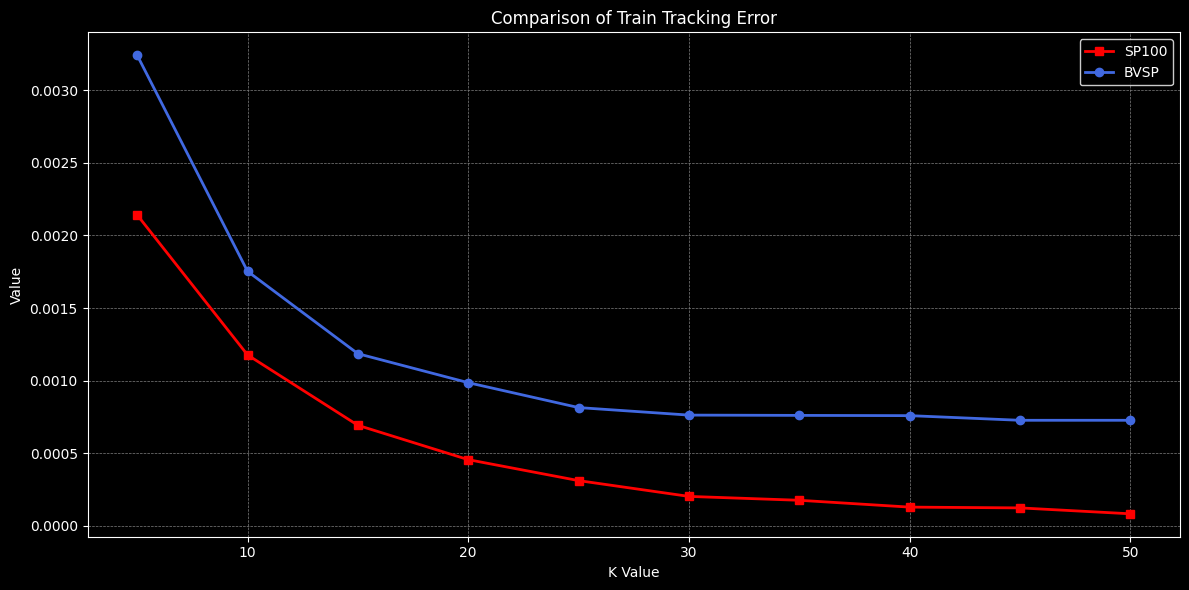

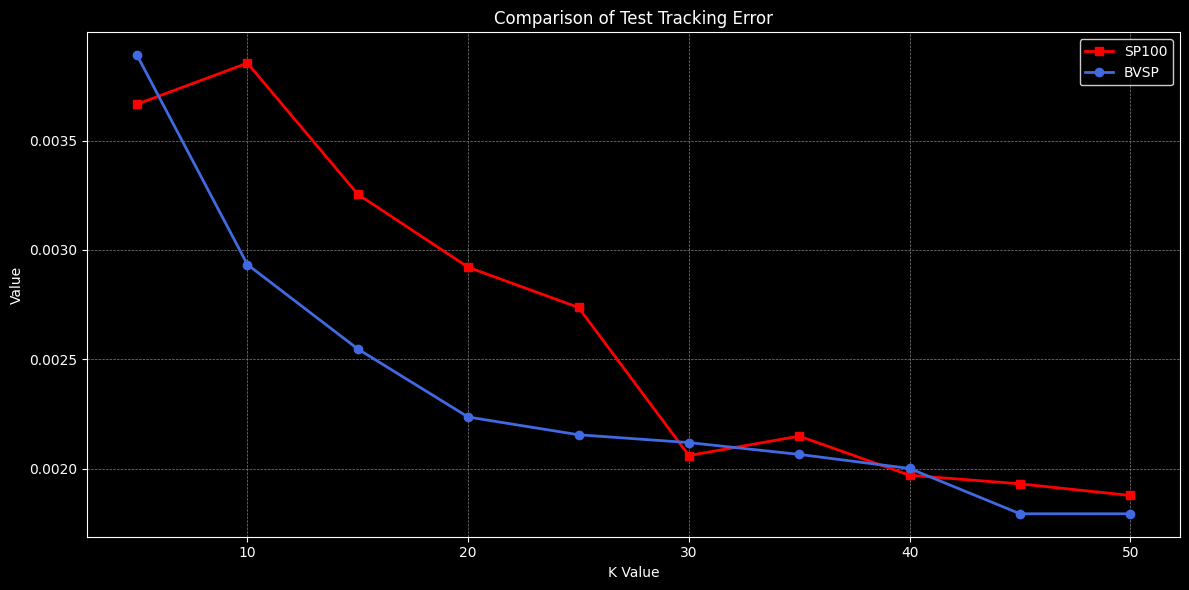

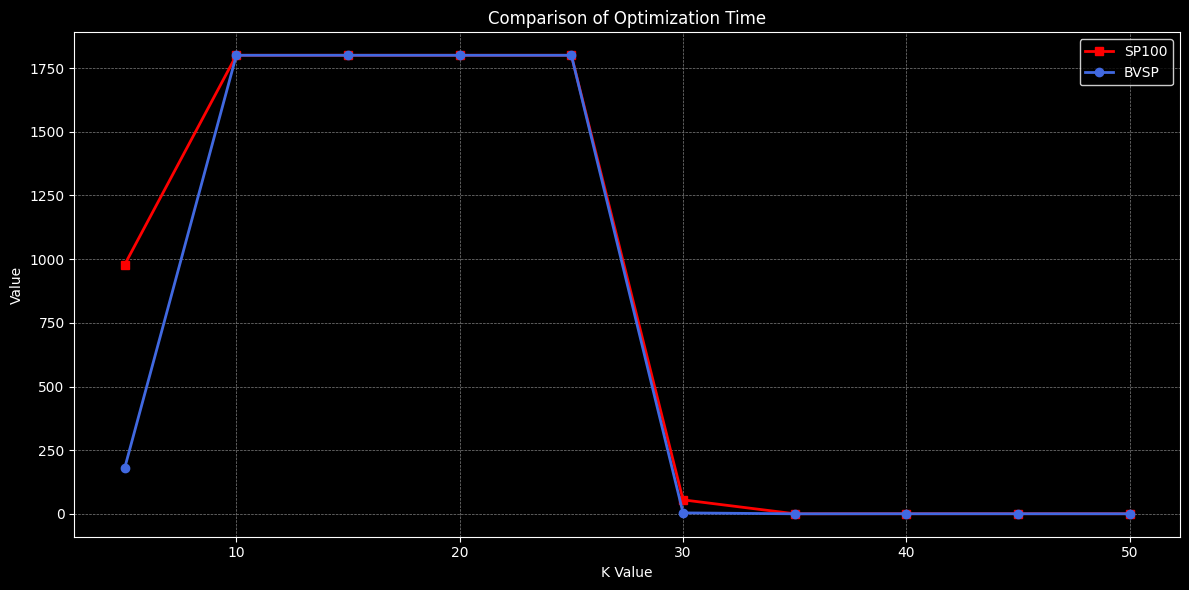

In [22]:
for metric_key, title in metrics_to_plot:
    plot_line_chart(
        metric_key, 
        bvsp_metrics[metric_key], 
        sp100_metrics[metric_key], 
        f'Comparison of {title}'
    )

## K's escolhidos

Não usar esses gráficos nos slides

* 10
* 20
* 30

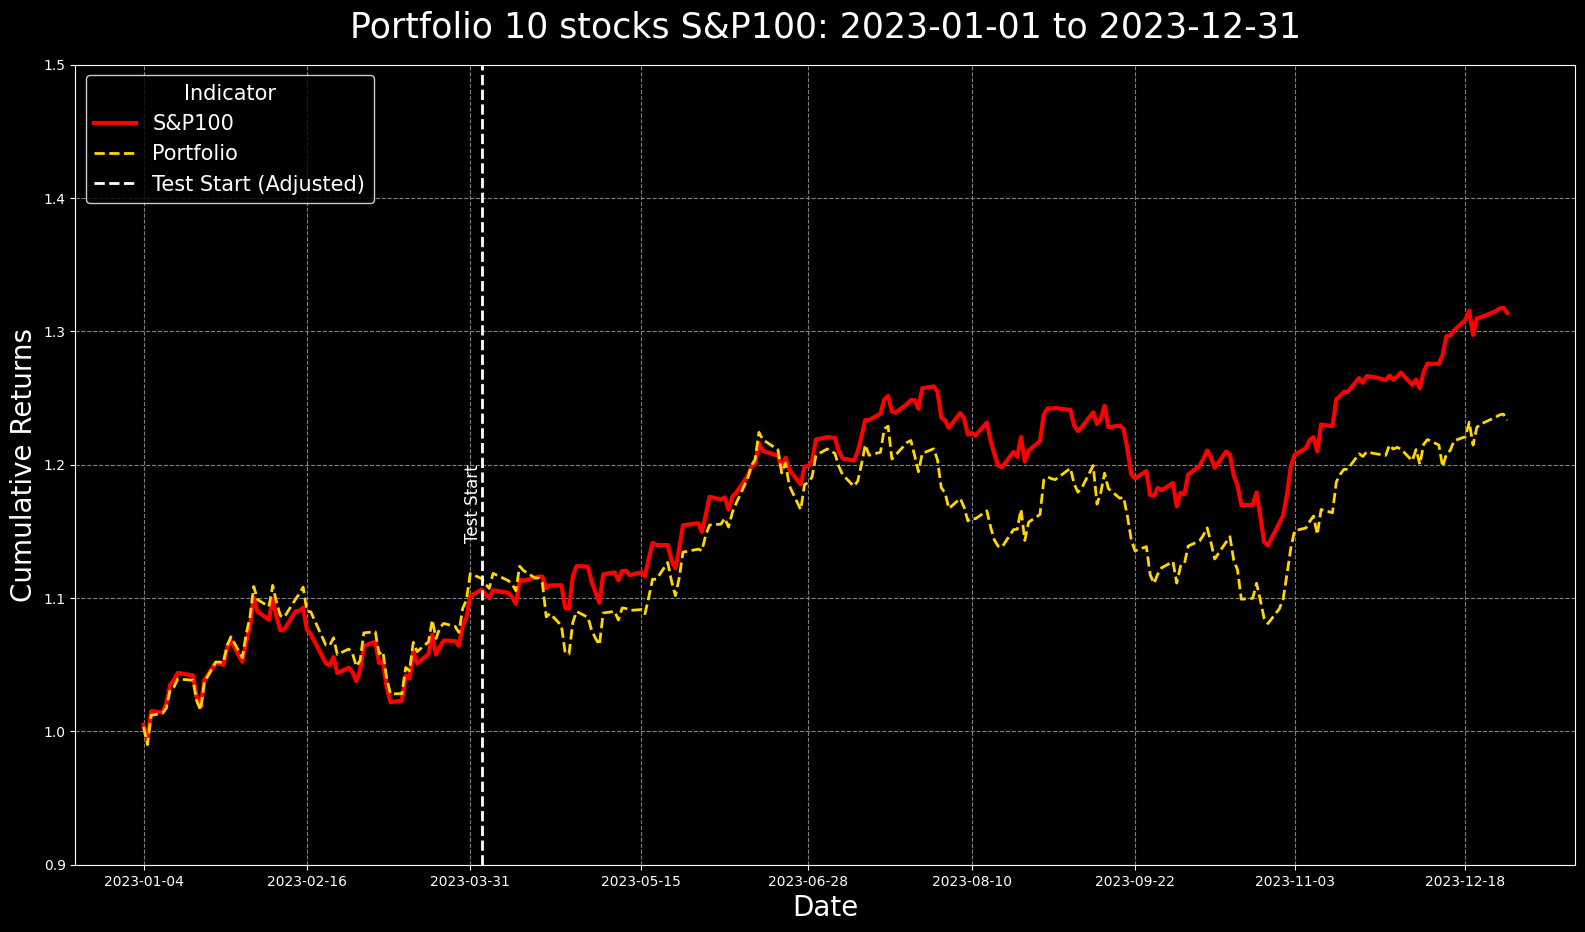

In [13]:
plot_portfolio(sp100_10k, sp100_data_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

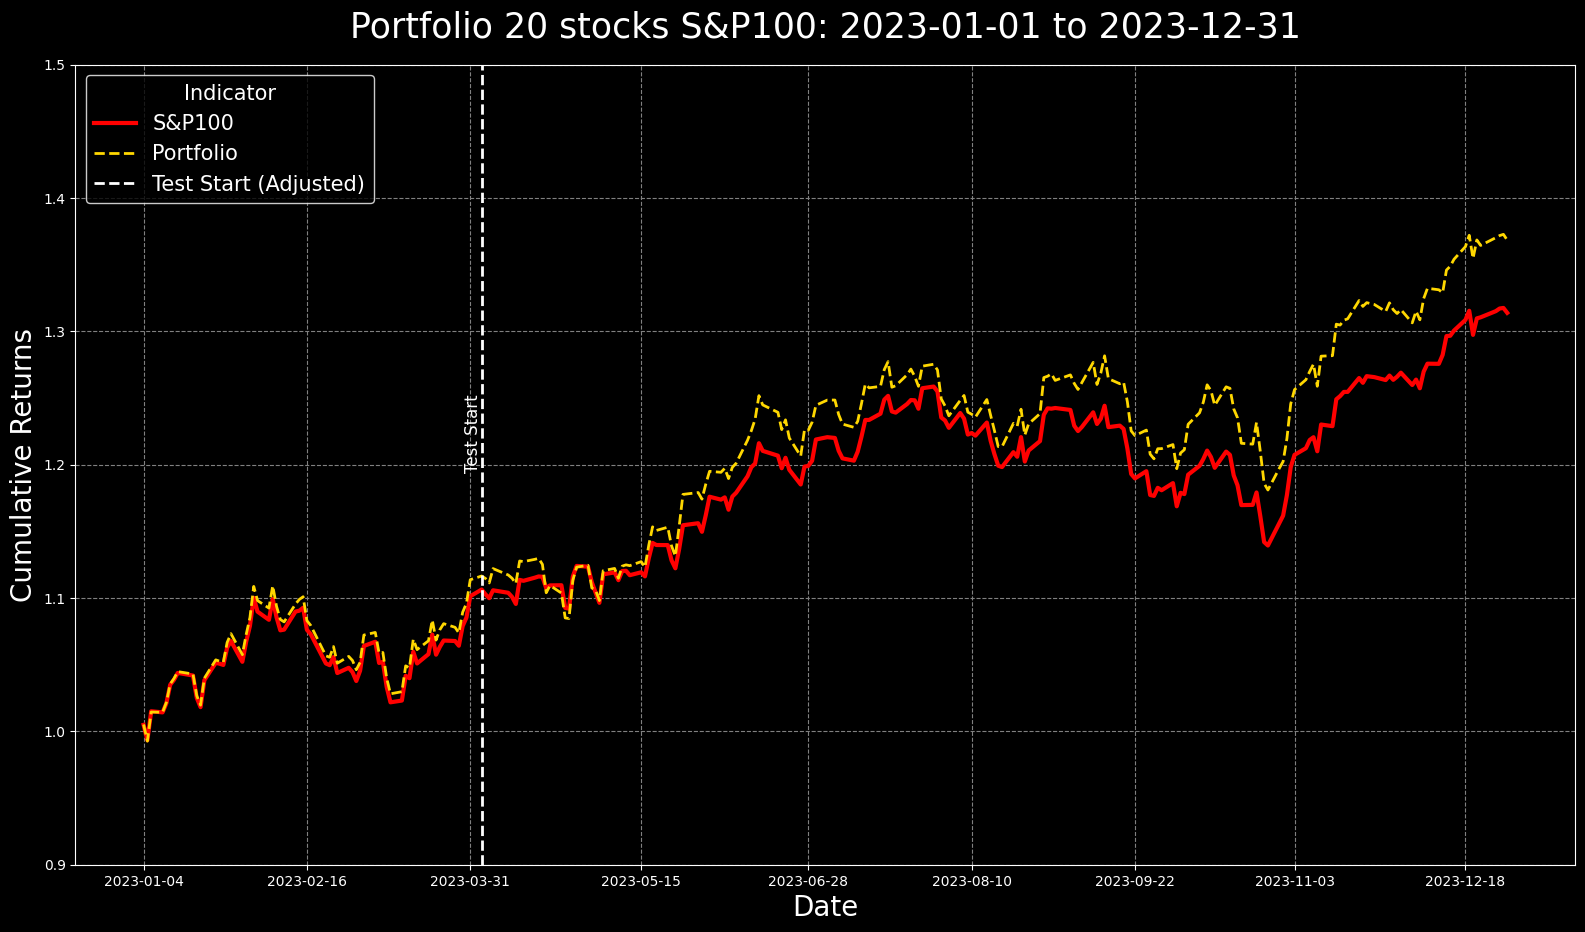

In [14]:
plot_portfolio(sp100_20k, sp100_data_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

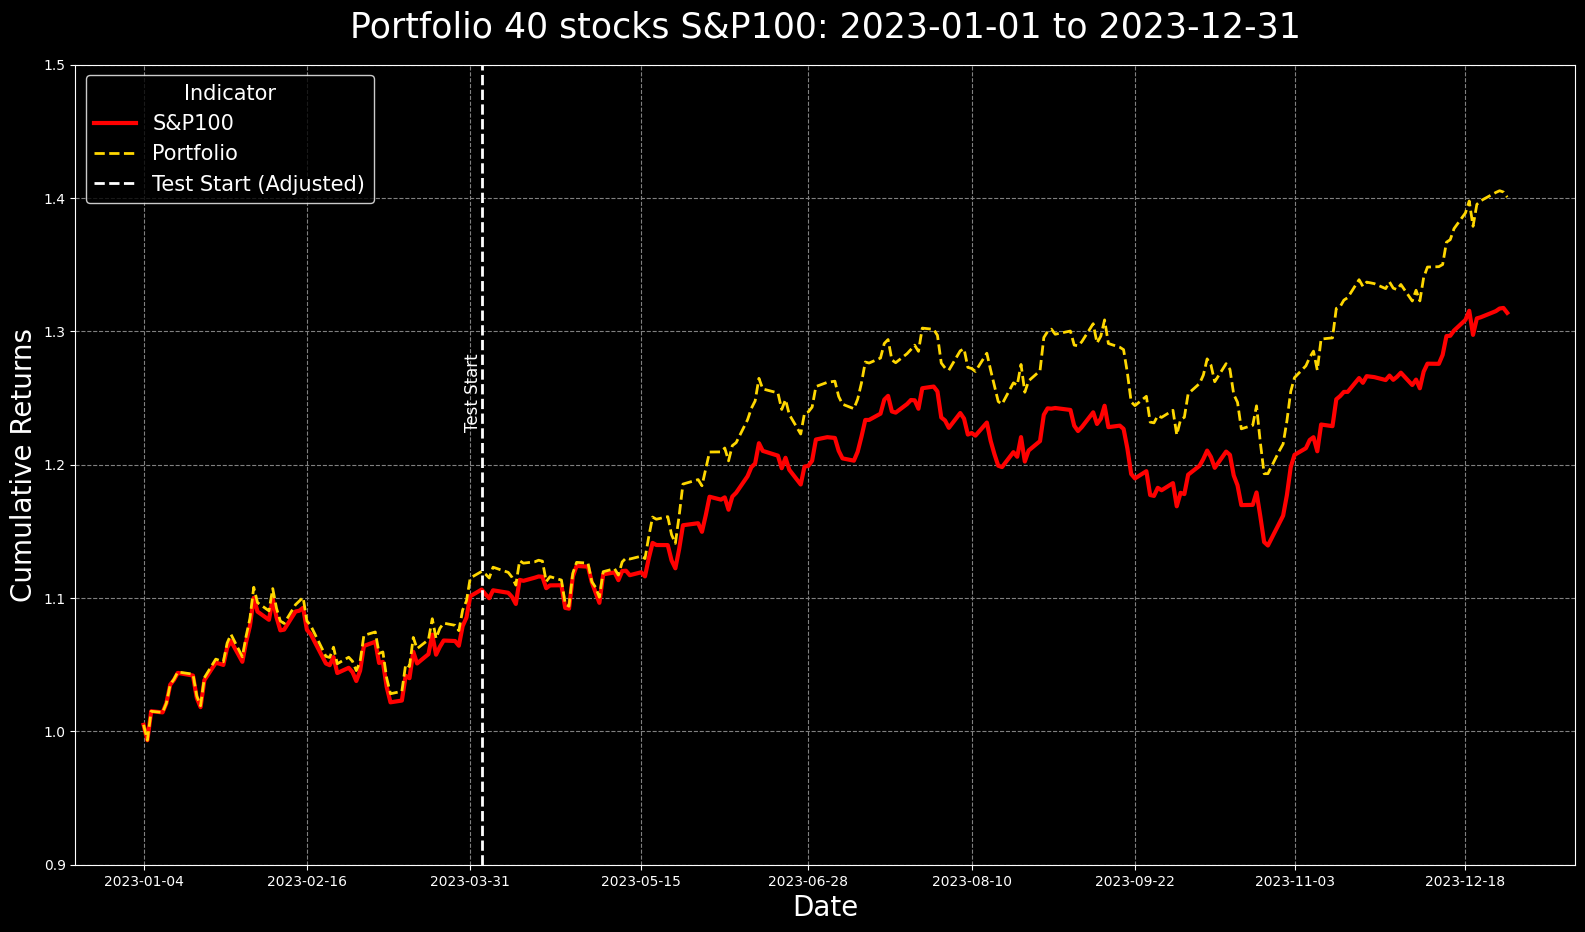

In [15]:
plot_portfolio(sp100_40k, sp100_data_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

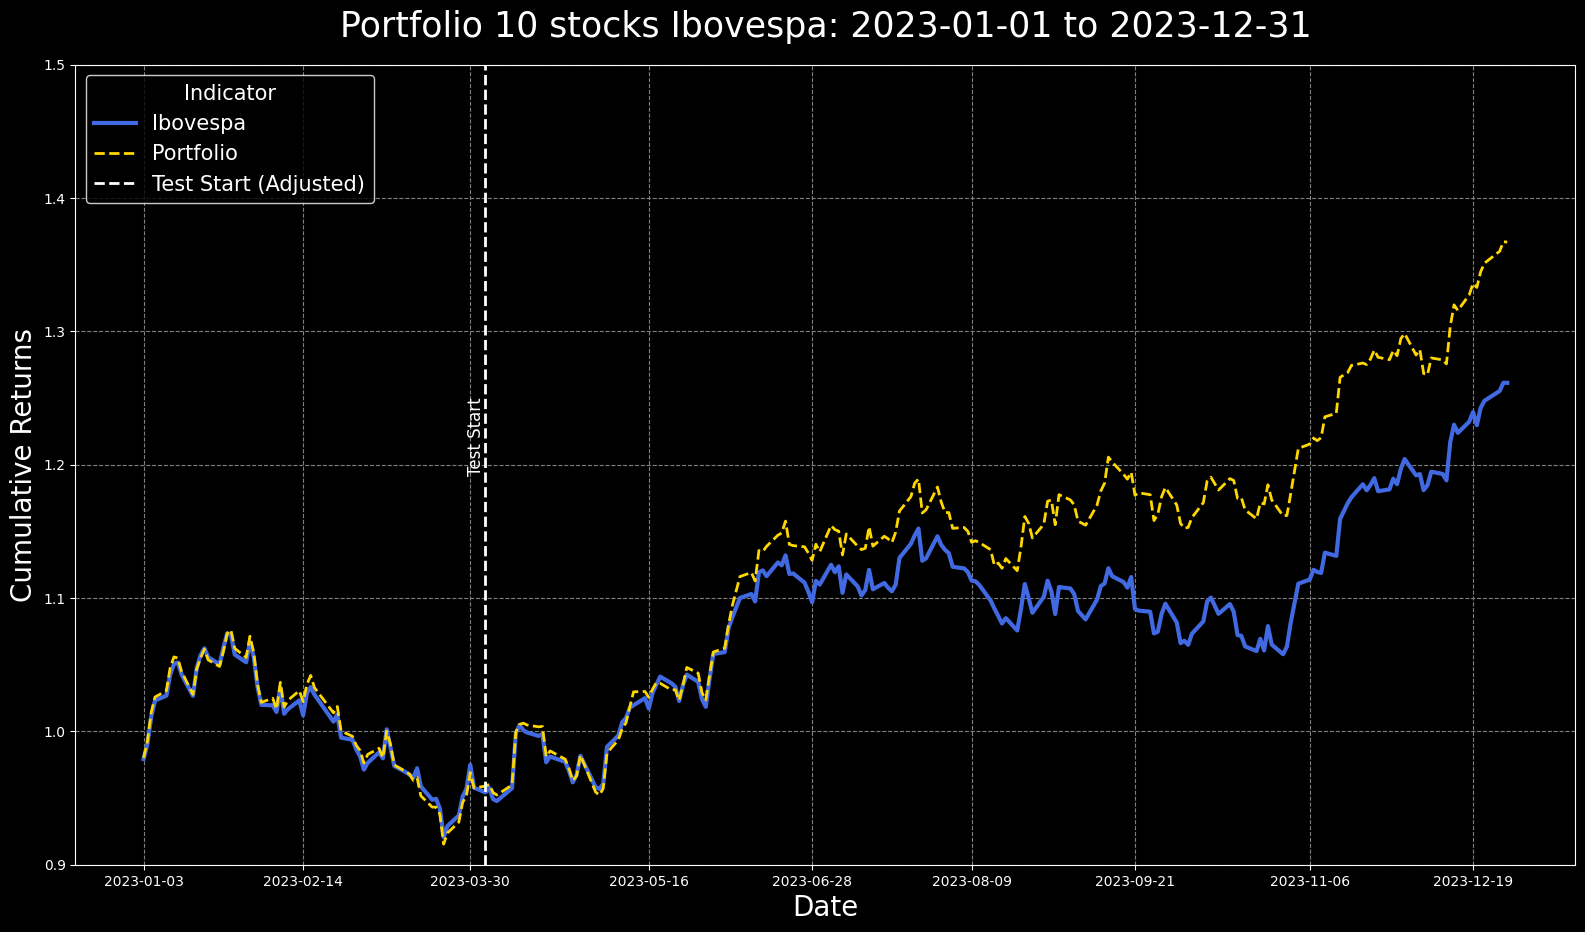

In [16]:
plot_portfolio(bvsp_10k, bvsp_data_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

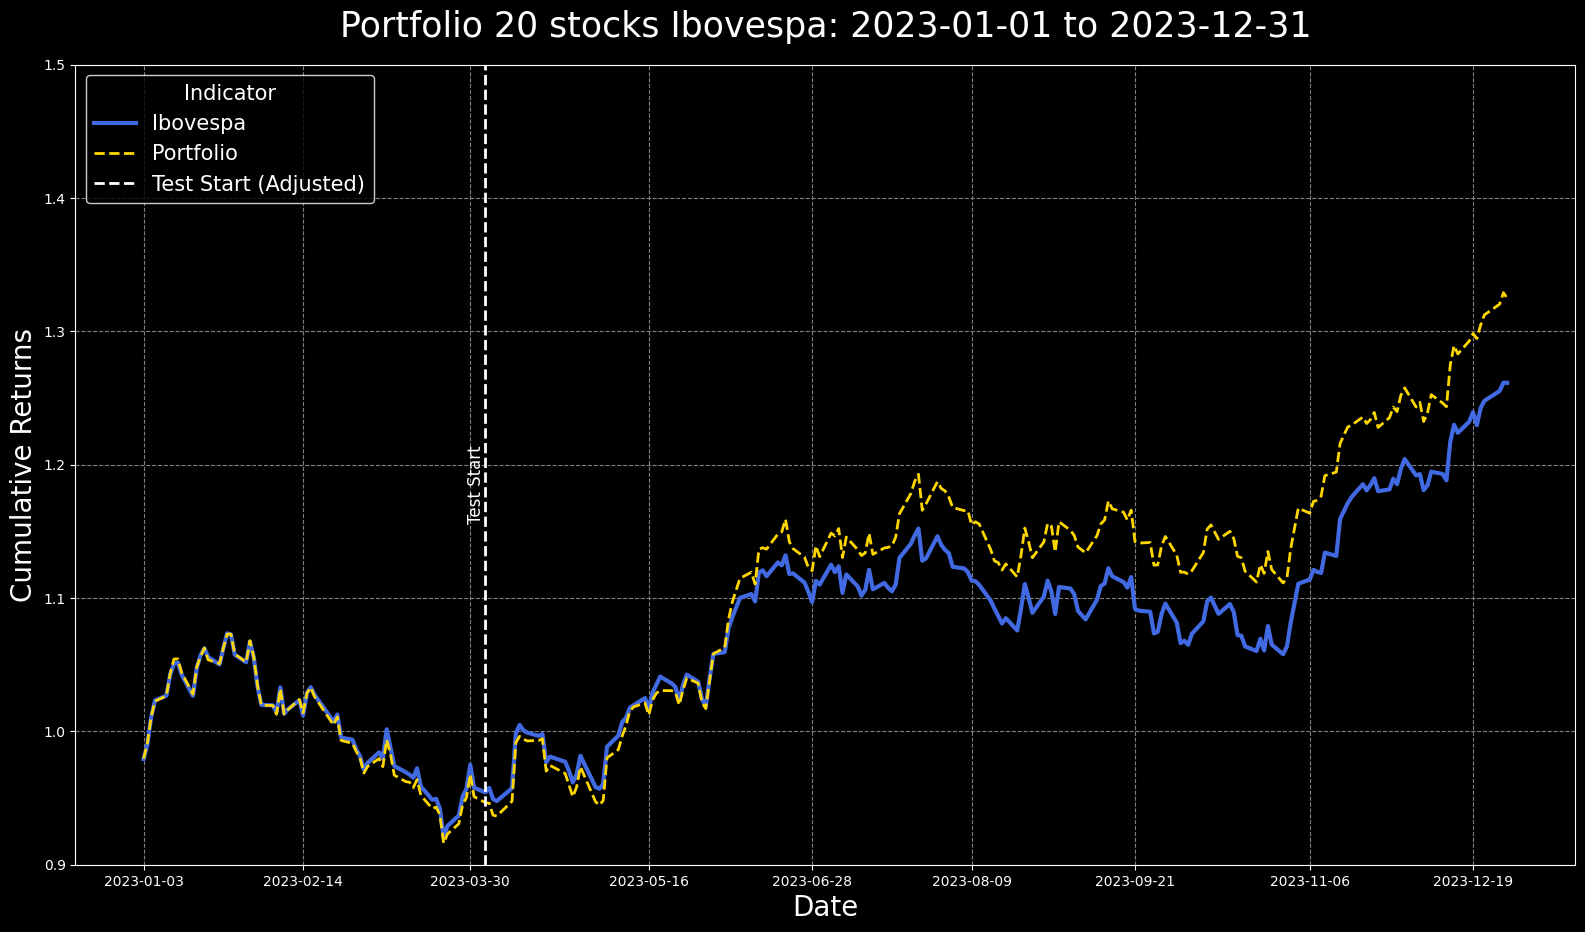

In [17]:
plot_portfolio(bvsp_20k, bvsp_data_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

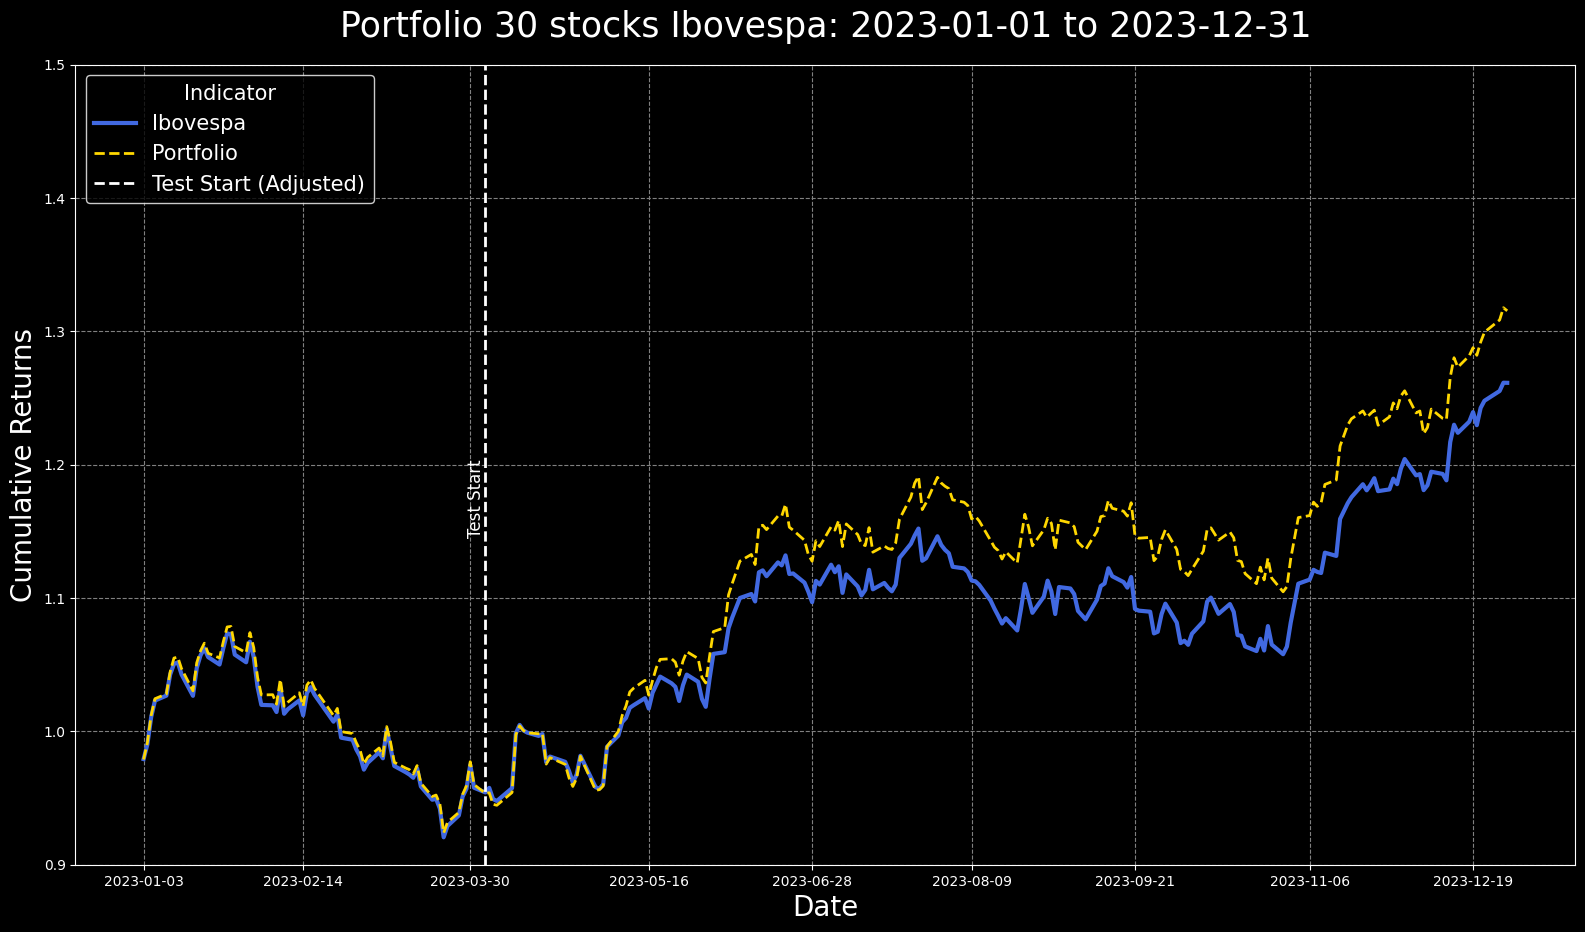

In [18]:
plot_portfolio(bvsp_30k, bvsp_data_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')